In [682]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import glob

from scipy.stats import pointbiserialr, spearmanr, pearsonr, chi2_contingency, zscore

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score

from IPython.display import clear_output
clear_output()

In [683]:
cctrans = pd.read_csv('CCTRANSACTIONS_Q42023_Q12024.csv')
ibft = pd.read_csv('IBFT_OUTGOING_Q42023_Q12024.csv')
products = pd.read_csv('PRODUCTS_Q42023_Q12024.csv')
segments = pd.read_csv('SEGMENTS_Q42023_Q12024.csv')

### **IBFT**

In [684]:
ibft

,CUSTOMER_ID,ACCOUNT_ID,RECEIVING_ALIEN_ID,RECEIVING_BANK_CODE,TRANSACTION_AMOUNT,TRANSACTION_DATE
0,4.919560e+07,8.940830e+07,3.061918e+06,BANK 1,12501.67,2023-10-01
1,2.936154e+07,8.390155e+07,3.177228e+06,BANK 2,3000.74,2023-10-01
2,1.308383e+08,3.977686e+07,1.031828e+06,BANK 2,17999.80,2023-10-01
3,4.389536e+07,5.691287e+07,5.076808e+06,BANK 3,9999.85,2023-10-01
4,2.693906e+07,5.886424e+07,3.574430e+06,BANK 2,2000.92,2023-10-01
...,...,...,...,...,...,...
339938,3.838652e+07,8.644802e+07,5.988383e+06,BANK 51,143.34,2024-03-10
339939,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,30000.42,2024-03-25
339940,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,20000.41,2024-03-24
339941,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,20000.85,2024-03-23


In [685]:
# Convert TRANSACTION_DATE to datetime
ibft['TRANSACTION_DATE'] = pd.to_datetime(ibft['TRANSACTION_DATE'])

# Extract quarter
ibft['QUARTER'] = ibft['TRANSACTION_DATE'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum TRANSACTION_AMOUNT
aggregated_ibft = ibft.groupby(['CUSTOMER_ID', 'QUARTER']).agg({'TRANSACTION_AMOUNT': 'sum'}).reset_index()

# Format QUARTER column
aggregated_ibft['QUARTER'] = aggregated_ibft['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Rename the column
aggregated_ibft = aggregated_ibft.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_IBFT'})

ibft = aggregated_ibft

### **Products**

In [686]:
products

,CUSTOMER_ID,SAVINGS_ACCOUNT_INDICATOR,CHECKING_ACCOUNT_INDICATOR,TIME_DEPOSIT_ACCOUNT_INDICATOR,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,PERSONAL_LOAN_INDICATOR,BB_LOAN_INDICATOR,LIFE_INSURANCE_INDICATOR,NONLIFE_INSURANCE_INDICATOR,INVESTMENT_INDICATOR,CURRENT_MONTH
0,4.302857e+03,1,0,0,0,0,0,0,0,0,0,10/2023
1,4.915714e+03,1,0,0,0,0,0,0,0,0,0,10/2023
2,5.658571e+03,1,0,0,0,0,0,0,1,0,0,10/2023
3,8.045714e+03,0,0,0,0,0,0,0,0,0,0,10/2023
4,1.047429e+04,0,0,0,0,0,0,0,1,0,0,10/2023
...,...,...,...,...,...,...,...,...,...,...,...,...
522404,1.428346e+08,1,0,0,0,0,0,0,0,0,0,03/2024
522405,1.428414e+08,0,0,0,0,0,0,0,0,0,0,03/2024
522406,1.428492e+08,1,1,0,0,0,1,1,1,0,0,03/2024
522407,1.428498e+08,0,0,0,0,0,0,0,0,0,0,03/2024


In [687]:
# Convert CURRENT_MONTH to datetime
products['CURRENT_MONTH'] = pd.to_datetime(products['CURRENT_MONTH'], format='%m/%Y')

# Extract quarter
products['QUARTER'] = products['CURRENT_MONTH'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum the specified columns
aggregated_products = products.groupby(['CUSTOMER_ID', 'QUARTER']).agg({
    'AUTO_LOAN_INDICATOR': 'sum',
    'HOUSING_LOAN_INDICATOR': 'sum',
    'SAVINGS_ACCOUNT_INDICATOR': 'sum'
}).reset_index()

# Format QUARTER column
aggregated_products['QUARTER'] = aggregated_products['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Display the updated dataframe
products = aggregated_products

### **Segments**

In [688]:
segments

,CUSTOMER_ID,CUSTOMER_GROUP,CUSTOMER_SEGMENT
0,1.371880e+08,RETAIL,Tier 6
1,7.363929e+07,RETAIL,Tier 6
2,6.190229e+07,RETAIL,Tier 6
3,6.333086e+07,RETAIL,Tier 6
4,3.761657e+07,RETAIL,Tier 6
...,...,...,...
99995,1.858279e+07,BUSINESS BANKING,NaN
99996,5.800595e+07,BUSINESS BANKING,NaN
99997,7.410509e+07,BUSINESS BANKING,NaN
99998,1.393309e+08,BUSINESS BANKING,NaN


In [689]:
# Drop the 'CUSTOMER_GROUP' column from the segments dataframe
segments = segments.drop(columns=['CUSTOMER_GROUP'])

# Remove rows where CUSTOMER_SEGMENT is null
segments = segments.dropna(subset=['CUSTOMER_SEGMENT'])

segments

,CUSTOMER_ID,CUSTOMER_SEGMENT
0,1.371880e+08,Tier 6
1,7.363929e+07,Tier 6
2,6.190229e+07,Tier 6
3,6.333086e+07,Tier 6
4,3.761657e+07,Tier 6
...,...,...
89995,1.190235e+08,Tier 4
89996,5.701052e+07,Tier 3
89997,1.142923e+07,Tier 3
89998,2.092495e+07,Tier 3


### **CC Transactions**

In [690]:
cctrans

,CUSTOMER_ID,CC_ACCOUNT_ID,MCC_CODE,TRANSACTION_AMOUNT,TRANSACTION_DATE,CARD_TYPE,CHANNEL
0,1.034364e+08,1.057741e+08,5411,1760.33,2023-10-01,PRE-NUMBERED EXPRESS CASH,PHYSICAL
1,1.030679e+08,6.238838e+07,5734,2719.64,2023-10-01,EMV Gold MC,ONLINE
2,8.738459e+07,4.900106e+07,5399,195.24,2023-10-01,Magstripe-Blue MC,ONLINE
3,1.034364e+08,1.057741e+08,5814,2469.54,2023-10-01,PRE-NUMBERED EXPRESS CASH,PHYSICAL
4,1.096100e+07,4.889572e+07,5814,251.62,2023-10-01,EMV Gold MC,ONLINE
...,...,...,...,...,...,...,...
535487,6.576957e+07,4.644408e+07,5541,4001.03,2024-03-27,EMV Gold MC,PHYSICAL
535488,1.302231e+08,8.134139e+07,5912,1501.13,2024-03-27,EMV Gold MC,PHYSICAL
535489,8.411550e+07,5.596352e+07,4814,199.31,2024-03-27,EMV Blue MC,ONLINE
535490,5.269180e+07,1.067314e+08,4814,2700.51,2024-03-29,BPI Platinum Rewards MC,ONLINE


In [691]:
# Convert TRANSACTION_DATE to datetime
cctrans['TRANSACTION_DATE'] = pd.to_datetime(cctrans['TRANSACTION_DATE'])

# Extract quarter
cctrans['QUARTER'] = cctrans['TRANSACTION_DATE'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum TRANSACTION_AMOUNT
aggregated_cctrans = cctrans.groupby(['CUSTOMER_ID', 'QUARTER']).agg({
    'TRANSACTION_AMOUNT': 'sum'
}).reset_index()

# Format QUARTER column
aggregated_cctrans['QUARTER'] = aggregated_cctrans['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Rename the column
aggregated_cctrans = aggregated_cctrans.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_CC'})

cctrans = aggregated_cctrans

### **Debit**

In [692]:
debit = pd.read_csv('debit_cleaned_aggregated.csv')
debit

,Unnamed: 0,CUSTOMER_ID,TRANSACTION_TYPE,QUARTER,TRANSACTION_AMOUNT
0,0,5.658571e+03,PHYSICAL,Q4 2023,1004.22
1,1,1.063143e+04,PHYSICAL,Q1 2024,114.71
2,2,1.111571e+04,PHYSICAL,Q1 2024,411.84
3,3,1.925857e+04,PHYSICAL,Q1 2024,419.28
4,4,1.925857e+04,PHYSICAL,Q4 2023,928.24
...,...,...,...,...,...
38015,38015,1.428346e+08,PHYSICAL,Q1 2024,6694.59
38016,38016,1.428346e+08,PHYSICAL,Q4 2023,8241.82
38017,38017,1.428492e+08,ONLINE,Q1 2024,418.25
38018,38018,1.428492e+08,PHYSICAL,Q1 2024,40000.07


In [693]:
# Remove the 'Unnamed: 0' and 'TRANSACTION_TYPE' columns from the debit dataframe
debit = debit.drop(columns=['Unnamed: 0', 'TRANSACTION_TYPE'])

# Rename the 'TRANSACTION_AMOUNT' column to 'TRANSACTION_AMOUNT_DEBIT'
debit = debit.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_DEBIT'})

debit

,CUSTOMER_ID,QUARTER,TRANSACTION_AMOUNT_DEBIT
0,5.658571e+03,Q4 2023,1004.22
1,1.063143e+04,Q1 2024,114.71
2,1.111571e+04,Q1 2024,411.84
3,1.925857e+04,Q1 2024,419.28
4,1.925857e+04,Q4 2023,928.24
...,...,...,...
38015,1.428346e+08,Q1 2024,6694.59
38016,1.428346e+08,Q4 2023,8241.82
38017,1.428492e+08,Q1 2024,418.25
38018,1.428492e+08,Q1 2024,40000.07


### **CDNA**

In [694]:
cdna = pd.read_csv('cdna_cleaned.csv')
cdna

,Unnamed: 0,CUSTOMER_ID,GENDER,AGE,MARITAL_STATUS,EDUCATION,BANK_TENURE,CUSTOMER_LOCATION,DIGITAL_INDICATOR,SEC,HOME_OWNER_INDICATOR,CAR_OWNER_INDICATOR,MONTHLY_INCOME,INCOME_SOURCE,ENVIRONMENTAL_AFF_INDICATOR,HUMANITARIAN_AFF_INDICATOR,OF_INDICATOR,RETIREES_INDICATOR,FILCHI_INDICATOR
0,0,4.598716e+06,FEMALE,43.67,MARRIED,MID,15.50,REGION VII (CENTRAL VISAYAS),TRADITIONAL,C1,Y,N,59465.23,COMMISSION,N,N,N,N,N
1,1,7.509760e+06,FEMALE,29.74,SINGLE,NO_DATA,2.59,NATIONAL CAPITAL REGION,DIGITAL,C1,Y,N,74533.25,SALARY,N,N,N,N,N
2,2,9.597760e+06,MALE,30.80,SINGLE,NO_DATA,1.92,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,102944.40,SALARY,N,N,N,N,N
3,3,1.749770e+07,MALE,31.85,SINGLE,MID,14.47,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,115609.09,SALARY,N,N,Y,N,N
4,4,1.758271e+07,FEMALE,53.92,SINGLE,MID,27.25,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,128745.85,REMITTANCE,N,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89720,91998,1.428473e+08,FEMALE,54.07,SEPARATED,MID,26.28,NO_DATA,NO_DATA,E,N,N,10000.07,ALLOWANCE,N,N,N,N,N
89721,91999,1.428492e+08,FEMALE,41.39,MARRIED,NO_DATA,6.25,REGION XIII (CARAGA),TRADITIONAL,B2,N,N,117034.58,BUSINESS,N,N,N,N,N
89722,92000,1.428498e+08,FEMALE,24.25,SINGLE,NO_DATA,-0.06,NO_DATA,NO_DATA,E,N,N,-0.75,SALARY,N,N,N,N,Y
89723,92001,1.428526e+08,FEMALE,33.07,MARRIED,MID,10.88,REGION X (NORTHERN MINDANAO),NO_DATA,B2,N,N,21665.74,SALARY,N,N,N,N,Y


In [695]:
# Select only the specified columns from the cdna dataframe
cdna = cdna[['CUSTOMER_ID','BANK_TENURE', 'SEC', 'DIGITAL_INDICATOR', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION', 'MONTHLY_INCOME']]

cdna

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME
0,4.598716e+06,15.50,C1,TRADITIONAL,REGION VII (CENTRAL VISAYAS),43.67,FEMALE,MID,59465.23
1,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25
2,9.597760e+06,1.92,B2,DIGITAL,NATIONAL CAPITAL REGION,30.80,MALE,NO_DATA,102944.40
3,1.749770e+07,14.47,B2,DIGITAL,NATIONAL CAPITAL REGION,31.85,MALE,MID,115609.09
4,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85
...,...,...,...,...,...,...,...,...,...
89720,1.428473e+08,26.28,E,NO_DATA,NO_DATA,54.07,FEMALE,MID,10000.07
89721,1.428492e+08,6.25,B2,TRADITIONAL,REGION XIII (CARAGA),41.39,FEMALE,NO_DATA,117034.58
89722,1.428498e+08,-0.06,E,NO_DATA,NO_DATA,24.25,FEMALE,NO_DATA,-0.75
89723,1.428526e+08,10.88,B2,NO_DATA,REGION X (NORTHERN MINDANAO),33.07,FEMALE,MID,21665.74


### **⚒️ Loan**

In [696]:
loan = pd.read_csv('loan_cleaned.csv')
loan

,Unnamed: 0,CUSTOMER_ID,Loan_to_Principal_Ratio,Interest_to_Principal_Percentage,Remaining_Loan_Term
0,0,1.001572e+07,1.832832,0.000323,238.400000
1,1,1.242506e+07,401896.977011,48.850575,60.866667
2,2,1.404520e+07,1.784351,-0.000011,184.666667
3,3,9.421564e+07,5.958568,-0.000009,123.800000
4,4,8.624422e+07,4.558156,0.000426,125.800000
...,...,...,...,...,...
35713,35713,1.187123e+08,1.000000,0.006733,36.500000
35714,35714,1.407766e+08,1.000000,-0.000168,30.466667
35715,35715,1.379087e+08,1.000000,-0.001550,12.166667
35716,35716,5.796677e+07,1.000000,0.000869,36.500000


In [697]:
# Select only the specified columns from the loan dataframe
#loan = loan[['CUSTOMER_ID', 'LOAN_BEHAVIOR', 'LOAN_AMOUNT']]

# Display the updated dataframe
#print(loan)

### **⚒️ CCConso**

In [698]:
ccconso = pd.read_csv('ccconso_cleaned_aggregated.csv')
ccconso

,Unnamed: 0,CUSTOMER_ID,CURRENT_MONTH,Credit_Utilization_Ratio,Payment_to_Billing_Ratio,Revolving_Balance_Ratio
0,0,5.962607e+07,2023-10-01,0.000477,100.000000,100.000000
1,1,1.240043e+08,2023-10-01,0.000123,100.000000,100.000000
2,3,1.075312e+08,2023-10-01,-0.000058,100.000000,100.000000
3,4,7.303243e+07,2023-10-01,56.850901,3.632009,38.448134
4,5,9.344397e+07,2023-10-01,221.594449,100.000000,0.001309
...,...,...,...,...,...,...
127598,143160,5.132595e+07,2024-03-01,10.945517,100.000000,-0.002771
127599,143161,5.132595e+07,2024-03-01,22.489791,100.000000,0.004535
127600,143162,5.132595e+07,2024-03-01,0.005700,100.000000,100.000000
127601,143163,5.132595e+07,2024-03-01,6.117577,100.065488,0.015646


In [699]:
# Select only the specified columns from the ccconso dataframe
#ccconso = ccconso[['CUSTOMER_ID', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING', 'PREVIOUS_MONTH_BILLING', 'REVOLVING_BALANCE']]

#ccconso

### **Merging Everything**

In [700]:
# List of dataframes to be merged
dataframes = [cdna, debit, 
              #loan, ccconso, 
              cctrans, ibft, products, segments]

In [701]:
# Merge the dataframes on 'CUSTOMER_ID' (and 'QUARTER' where applicable)
combined_df = pd.merge(cdna, debit, on='CUSTOMER_ID', how='inner')
combined_df = pd.merge(combined_df, cctrans, on=['CUSTOMER_ID', 'QUARTER'], how='inner')

combined_df = pd.merge(combined_df, ibft, on=['CUSTOMER_ID', 'QUARTER'], how='inner')
combined_df = pd.merge(combined_df, products, on=['CUSTOMER_ID', 'QUARTER'], how='inner')
combined_df = pd.merge(combined_df, segments, on='CUSTOMER_ID', how='inner')

combined_df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,TRANSACTION_AMOUNT_DEBIT,TRANSACTION_AMOUNT_CC,TRANSACTION_AMOUNT_IBFT,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT
0,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25,Q1 2024,3042.94,12581.32,21498.75,0,0,3,Tier 5
1,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25,Q1 2024,2516.71,12581.32,21498.75,0,0,3,Tier 5
2,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25,Q4 2023,8124.82,31757.35,1722.03,0,0,3,Tier 5
3,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25,Q4 2023,6160.50,31757.35,1722.03,0,0,3,Tier 5
4,9.597760e+06,1.92,B2,DIGITAL,NATIONAL CAPITAL REGION,30.80,MALE,NO_DATA,102944.40,Q1 2024,36971.75,32451.76,55001.23,0,0,3,Tier 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4964,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q1 2024,13332.36,126939.23,97592.72,0,0,3,Tier 5
4965,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q4 2023,53503.62,109532.61,18939.28,0,0,3,Tier 5
4966,1.427146e+08,14.92,C2,DIGITAL,NATIONAL CAPITAL REGION,45.01,MALE,MID,28039.54,Q1 2024,2722.52,2399.97,8763.03,0,0,3,Tier 6
4967,1.427146e+08,14.92,C2,DIGITAL,NATIONAL CAPITAL REGION,45.01,MALE,MID,28039.54,Q4 2023,11090.69,589.32,10156.27,0,0,3,Tier 6


In [702]:
# Remove rows where DIGITAL_INDICATOR or EDUCATION is NO_DATA
combined_df = combined_df[(combined_df['DIGITAL_INDICATOR'] != 'NO_DATA') & (combined_df['EDUCATION'] != 'NO_DATA')]

# Remove rows where TRANSACTION_AMOUNT_DEBIT or MONTHLY_INCOME is null
combined_df = combined_df.dropna(subset=['TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME'])

combined_df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,TRANSACTION_AMOUNT_DEBIT,TRANSACTION_AMOUNT_CC,TRANSACTION_AMOUNT_IBFT,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT
6,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,41501.74,24432.20,4500.87,0,0,3,Tier 1
7,2.294175e+07,1.44,C2,TRADITIONAL,NATIONAL CAPITAL REGION,30.38,MALE,MID,41355.90,Q4 2023,7668.34,8825.71,998.80,0,0,3,Tier 6
8,5.354615e+07,5.87,B1,DIGITAL,NATIONAL CAPITAL REGION,30.10,FEMALE,MID,153427.84,Q1 2024,9185.01,51070.53,87674.70,0,0,3,Tier 3
9,5.354615e+07,5.87,B1,DIGITAL,NATIONAL CAPITAL REGION,30.10,FEMALE,MID,153427.84,Q4 2023,153687.35,103713.66,122599.78,0,0,3,Tier 3
10,7.469016e+07,6.20,A,DIGITAL,REGION VI (WESTERN VISAYAS),42.05,FEMALE,MID,244954.19,Q1 2024,8912.96,1989.17,954501.99,0,0,3,Tier 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q1 2024,21122.57,40153.14,921545.85,3,0,3,Tier 3
4962,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q4 2023,4876.27,12611.89,122298.42,3,0,3,Tier 3
4966,1.427146e+08,14.92,C2,DIGITAL,NATIONAL CAPITAL REGION,45.01,MALE,MID,28039.54,Q1 2024,2722.52,2399.97,8763.03,0,0,3,Tier 6
4967,1.427146e+08,14.92,C2,DIGITAL,NATIONAL CAPITAL REGION,45.01,MALE,MID,28039.54,Q4 2023,11090.69,589.32,10156.27,0,0,3,Tier 6


In [703]:
combined_df.columns

Index(['CUSTOMER_ID', 'BANK_TENURE', 'SEC', 'DIGITAL_INDICATOR',
       'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION', 'MONTHLY_INCOME',
       'QUARTER', 'TRANSACTION_AMOUNT_DEBIT', 'TRANSACTION_AMOUNT_CC',
       'TRANSACTION_AMOUNT_IBFT', 'AUTO_LOAN_INDICATOR',
       'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR',
       'CUSTOMER_SEGMENT'],
      dtype='object')

### **Identify and Reduce Redundancy within Each Concept**

In [704]:
df = combined_df.copy()

concepts = {
    "Financial Health": [
        'TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME'
    ],
    "Credit Reliability": [
        'AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 
        'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR'
    ],
    "Customer Engagement": [
        'BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 
        'TRANSACTION_AMOUNT_CC'
    ],
    "Socioeconomic Stability": [
        'SEC', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION'
    ]
}

In [705]:
# Display information about the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4257 entries, 6 to 4968
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CUSTOMER_ID                4257 non-null   float64
 1   BANK_TENURE                4257 non-null   float64
 2   SEC                        4257 non-null   object 
 3   DIGITAL_INDICATOR          4257 non-null   object 
 4   CUSTOMER_LOCATION          4257 non-null   object 
 5   AGE                        4257 non-null   float64
 6   GENDER                     4257 non-null   object 
 7   EDUCATION                  4257 non-null   object 
 8   MONTHLY_INCOME             4257 non-null   float64
 9   QUARTER                    4257 non-null   object 
 10  TRANSACTION_AMOUNT_DEBIT   4257 non-null   float64
 11  TRANSACTION_AMOUNT_CC      4257 non-null   float64
 12  TRANSACTION_AMOUNT_IBFT    4257 non-null   float64
 13  AUTO_LOAN_INDICATOR        4257 non-null   int64  
 1

BANK_TENURE: numerical <br>
SEC: nominal <br>
DIGITAL_INDICATOR: binary ['DIGITAL', 'TRADITIONAL'] <br>
CUSTOMER_LOCATION: nominal [Philippine regions] <br>
AGE: numerical <br>
GENDER: binary <br>
EDUCATION: nominal, ordinal ['MID', 'HIGH', 'LOW']<br>
MONTHLY_INCOME: numerical<br>
QUARTER: nominal<br>
TRANSACTION_AMOUNT_DEBIT: numerical<br>
TRANSACTION_AMOUNT_CC: numerical<br>
TRANSACTION_AMOUNT_IBFT: numerical<br>
AUTO_LOAN_INDICATOR: numerical<br>
HOUSING_LOAN_INDICATOR: numerical<br>
SAVINGS_ACCOUNT_INDICATOR: numerical<br>
CUSTOMER_SEGMENT: nominal, ordinal (highest is Tier 1)

We remove a feature when it has correlation with another feature greater than or equal to 0.8.

#### **Financial Health**

Pearson Correlation between TRANSACTION_AMOUNT_DEBIT and MONTHLY_INCOME: 0.17606335145730678
P-value: 5.547742679851051e-31


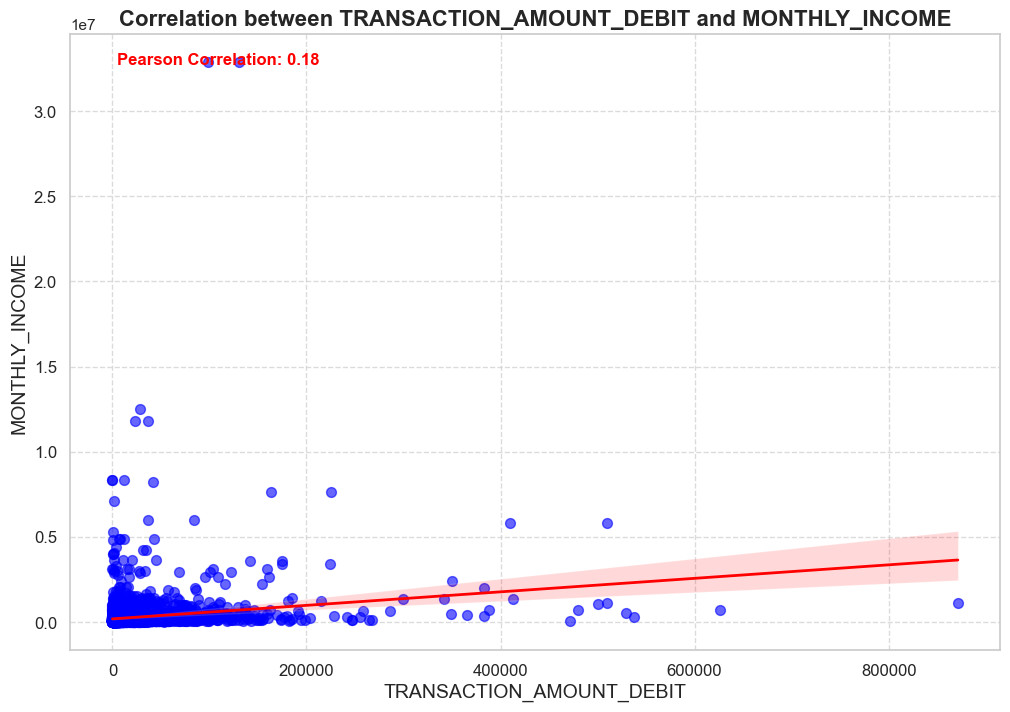

In [706]:
# Compute Pearson correlation
corr, p_value = pearsonr(df['TRANSACTION_AMOUNT_DEBIT'], df['MONTHLY_INCOME'])

print(f"Pearson Correlation between TRANSACTION_AMOUNT_DEBIT and MONTHLY_INCOME: {corr}")
print(f"P-value: {p_value}")

# Create a scatter plot with a regression line
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with regression line
scatter_plot = sns.regplot(x='TRANSACTION_AMOUNT_DEBIT', y='MONTHLY_INCOME', data=df, 
                           scatter_kws={'s':50, 'alpha':0.6, 'color':'blue'}, 
                           line_kws={'color':'red', 'lw':2})

# Add titles and labels
plt.title('Correlation between TRANSACTION_AMOUNT_DEBIT and MONTHLY_INCOME', fontsize=16, fontweight='bold')
plt.xlabel('TRANSACTION_AMOUNT_DEBIT', fontsize=14)
plt.ylabel('MONTHLY_INCOME', fontsize=14)

# Annotate the plot with the Pearson correlation coefficient
plt.annotate(f'Pearson Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red', fontweight='bold')

# Customize the ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### **Credit Reliability**

*Point Biserial Correlation*

In [707]:
# Features for Credit Reliability concept
credit_reliability_features = ['AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR']

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=credit_reliability_features, columns=credit_reliability_features)

# Ensure that the binary variable is properly encoded as numeric values (0 and 1)
df['DIGITAL_INDICATOR'] = df['DIGITAL_INDICATOR'].map({'DIGITAL': 1, 'TRADITIONAL': 0})

# Compute correlations
for i in range(len(credit_reliability_features)):
    for j in range(i, len(credit_reliability_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[credit_reliability_features[i]]
            var2 = df[credit_reliability_features[j]]
            
            if var1.nunique() == 2 and var2.nunique() != 2:
                corr, _ = pointbiserialr(var1, var2)
            elif var2.nunique() == 2 and var1.nunique() != 2:
                corr, _ = pointbiserialr(var2, var1)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

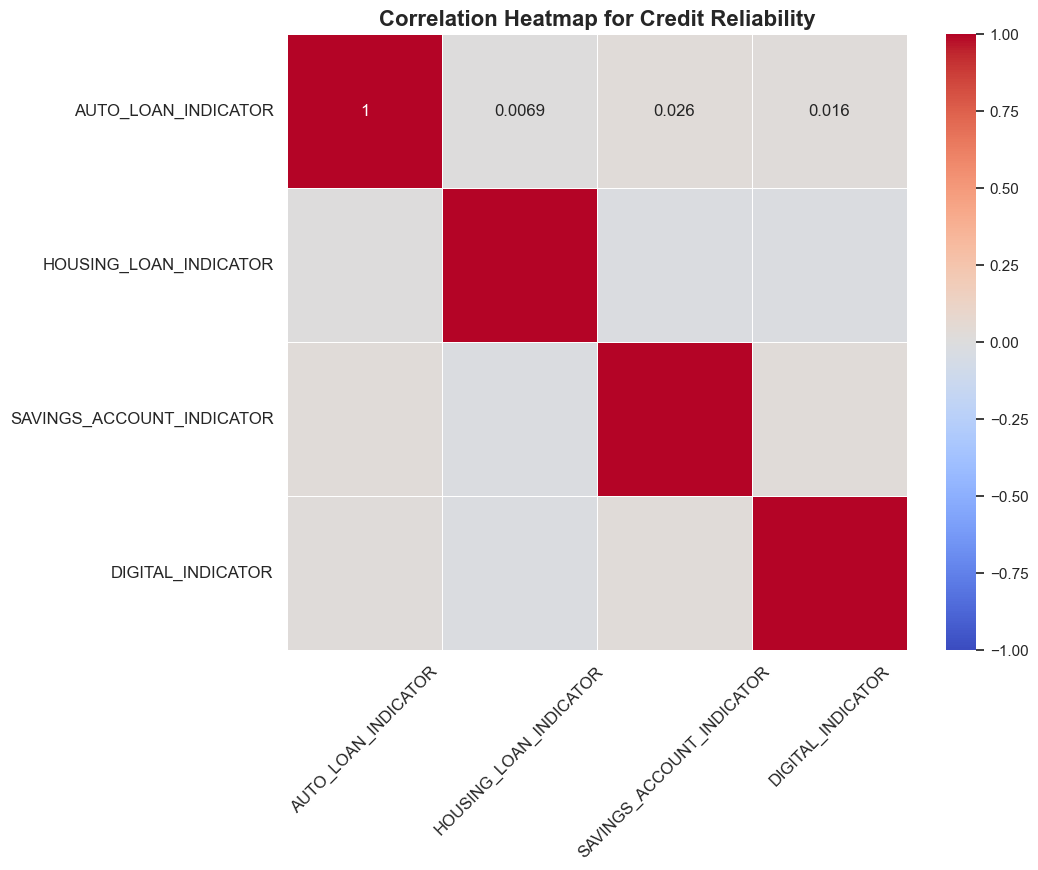

In [708]:
# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Credit Reliability', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

#### **Customer Engagement**

*Spearman Correlation*

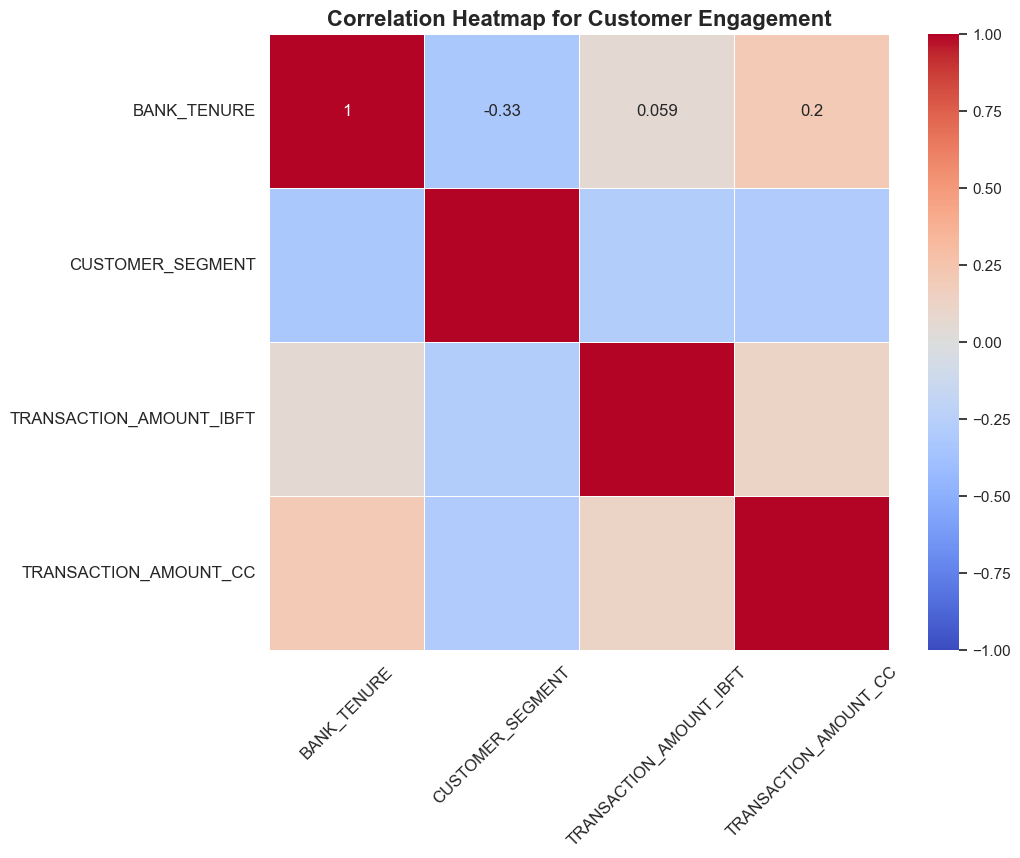

In [709]:
# Features for Customer Engagement concept
customer_engagement_features = ['BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 'TRANSACTION_AMOUNT_CC']

# Convert CUSTOMER_SEGMENT to ordinal ranks
segment_mapping = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3, 'Tier 4': 4, 'Tier 5': 5, 'Tier 6': 6}
df['CUSTOMER_SEGMENT'] = df['CUSTOMER_SEGMENT'].map(segment_mapping)

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=customer_engagement_features, columns=customer_engagement_features)

# Compute correlations
for i in range(len(customer_engagement_features)):
    for j in range(i, len(customer_engagement_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[customer_engagement_features[i]]
            var2 = df[customer_engagement_features[j]]
            
            if customer_engagement_features[i] == 'CUSTOMER_SEGMENT' or customer_engagement_features[j] == 'CUSTOMER_SEGMENT':
                corr, _ = spearmanr(var1, var2)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Customer Engagement', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

#### **Socioeconomic Stability**

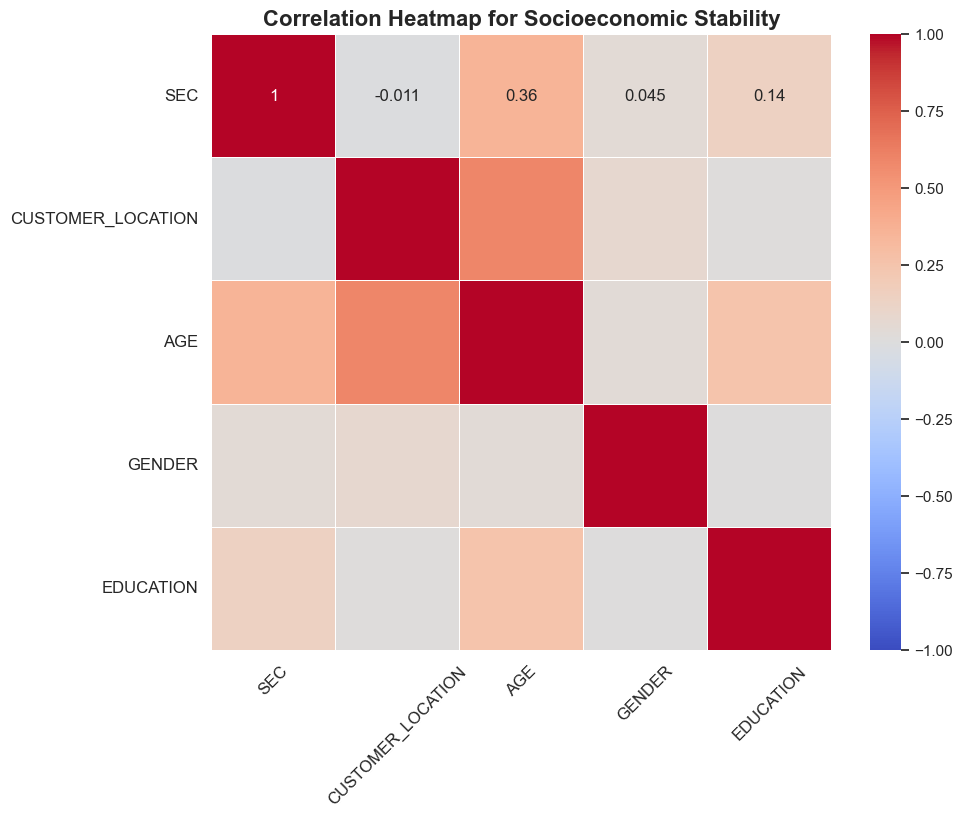

In [710]:
# Features for Socioeconomic Stability concept
socioeconomic_stability_features = ['SEC', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION']

# Convert SEC to ordinal ranks
sec_mapping = {'E': 1, 'D': 2, 'C2': 3, 'C1': 4, 'B2': 5, 'B1': 6, 'A': 7}
df['SEC'] = df['SEC'].map(sec_mapping)

# Convert GENDER to binary values
df['GENDER'] = df['GENDER'].map({'MALE': 1, 'FEMALE': 0})

# Convert EDUCATION to ordinal ranks
education_mapping = {'LOW': 1, 'MID': 2, 'HIGH': 3}
df['EDUCATION'] = df['EDUCATION'].map(education_mapping)

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=socioeconomic_stability_features, columns=socioeconomic_stability_features)

# Compute correlations
for i in range(len(socioeconomic_stability_features)):
    for j in range(i, len(socioeconomic_stability_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[socioeconomic_stability_features[i]]
            var2 = df[socioeconomic_stability_features[j]]
            
            if socioeconomic_stability_features[i] in ['SEC', 'EDUCATION'] or socioeconomic_stability_features[j] in ['SEC', 'EDUCATION']:
                corr, _ = spearmanr(var1, var2)
            elif socioeconomic_stability_features[i] == 'CUSTOMER_LOCATION' or socioeconomic_stability_features[j] == 'CUSTOMER_LOCATION':
                corr = cramers_v(var1, var2)
            elif socioeconomic_stability_features[i] == 'GENDER' or socioeconomic_stability_features[j] == 'GENDER':
                corr, _ = pointbiserialr(var1, var2)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Socioeconomic Stability', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

### **Check Cross-Concept Correlations for Distinctiveness**

Cross-Concept Correlation Matrix:
                                SEC  CUSTOMER_LOCATION       AGE    GENDER  \
TRANSACTION_AMOUNT_DEBIT   0.280910           0.025288  0.161480  0.025592   
MONTHLY_INCOME             0.956746           0.668949  0.179440  0.043022   
AUTO_LOAN_INDICATOR        0.170390           0.088801  0.053569  0.032213   
HOUSING_LOAN_INDICATOR     0.121445           0.062527  0.083551  0.018690   
SAVINGS_ACCOUNT_INDICATOR -0.060572           0.000000 -0.110232 -0.019977   
DIGITAL_INDICATOR          0.080739           0.131141 -0.098319 -0.054772   
BANK_TENURE                0.336739           0.536605  0.625945  0.016884   
CUSTOMER_SEGMENT          -0.619599           0.093332 -0.335360 -0.058127   
TRANSACTION_AMOUNT_IBFT    0.469757           0.445058  0.093105  0.007585   
TRANSACTION_AMOUNT_CC      0.339680           0.444116  0.188423  0.007454   

                           EDUCATION  
TRANSACTION_AMOUNT_DEBIT    0.046968  
MONTHLY_INCOME              0

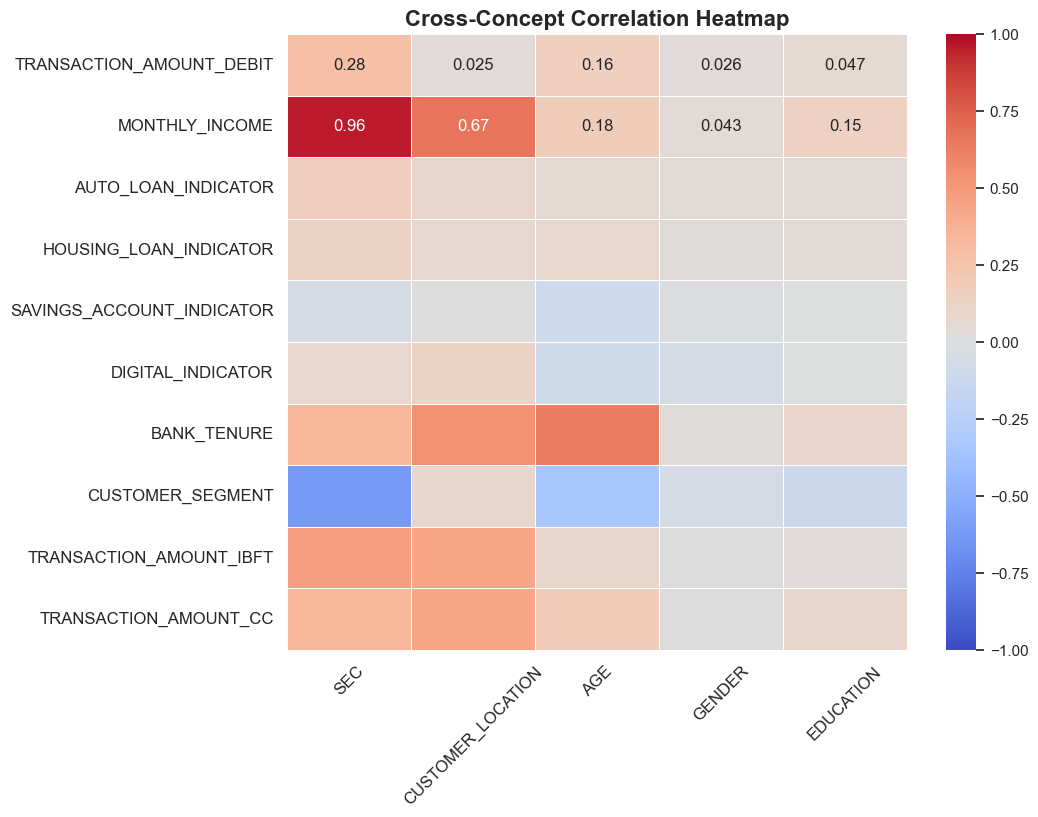

In [711]:
# Features for each concept
financial_health_features = ['TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME']
credit_reliability_features = ['AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR']
customer_engagement_features = ['BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 'TRANSACTION_AMOUNT_CC']
socioeconomic_stability_features = ['SEC', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION']

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Initialize an empty correlation matrix for cross-concept correlations
cross_concept_corr_matrix = pd.DataFrame(index=financial_health_features + credit_reliability_features + customer_engagement_features, columns=socioeconomic_stability_features)

# Compute cross-concept correlations
for i in range(len(cross_concept_corr_matrix.index)):
    for j in range(len(cross_concept_corr_matrix.columns)):
        var1 = df[cross_concept_corr_matrix.index[i]]
        var2 = df[cross_concept_corr_matrix.columns[j]]
        
        if cross_concept_corr_matrix.columns[j] in ['SEC', 'EDUCATION']:
            corr, _ = spearmanr(var1, var2)
        elif cross_concept_corr_matrix.columns[j] == 'CUSTOMER_LOCATION':
            corr = cramers_v(var1, var2)
        elif cross_concept_corr_matrix.columns[j] == 'GENDER':
            corr, _ = pointbiserialr(var1, var2)
        else:
            corr, _ = pearsonr(var1, var2)
            
        cross_concept_corr_matrix.iloc[i, j] = corr

# Convert the correlation matrix to float
cross_concept_corr_matrix = cross_concept_corr_matrix.astype(float)

# Display the cross-concept correlation matrix
print("Cross-Concept Correlation Matrix:")
print(cross_concept_corr_matrix)

# Identify and retain indicators with low correlation (e.g., correlation coefficient < 0.3)
threshold = 0.3
low_corr_elements = cross_concept_corr_matrix[(cross_concept_corr_matrix < threshold) & (cross_concept_corr_matrix > -threshold)].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Display the retained elements
print("Retained Elements with Correlation Coefficient < 0.3:")
print(low_corr_elements)

# Create a heatmap for the original cross-concept correlation matrix
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(cross_concept_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Cross-Concept Correlation Heatmap', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

Between Monthly Income, SEC, and Customer Location we keep **Montly Income** since it is continuous and easier to deal with.

### **Computation of the Overall Resilience Score**

The new set of features for each concept is as follows:

In [712]:
concepts = {
    "Financial Health": [
        'TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME'
    ],
    "Credit Reliability": [
        'AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 
        'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR'
    ],
    "Customer Engagement": [
        'BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 
        'TRANSACTION_AMOUNT_CC'
    ],
    "Socioeconomic Stability": [
        'AGE', 'GENDER', 'EDUCATION'
    ]
}

We first standardize each selected indicator to a z-score and calculate composite scores.

In [713]:
for concept, features in concepts.items():
    df[features] = df[features].apply(zscore)
    df[f'{concept}_Score'] = df[features].mean(axis=1)

Then, combine concept scores into an overall resilience score.

In [714]:
df['Resilience_Score'] = df[[f'{concept}_Score' for concept in concepts]].mean(axis=1)

df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,TRANSACTION_AMOUNT_IBFT,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT,Financial Health_Score,Credit Reliability_Score,Customer Engagement_Score,Socioeconomic Stability_Score,Resilience_Score
6,1.758271e+07,2.958097,5,0.342524,NATIONAL CAPITAL REGION,1.714890,-0.766707,0.156983,-0.149281,Q1 2024,...,-0.456115,-0.260116,-0.140545,0.152263,-2.182167,0.185887,0.023531,-0.008582,0.368388,0.142306
7,2.294175e+07,-1.511193,3,-2.919502,NATIONAL CAPITAL REGION,-0.693204,1.304278,0.156983,-0.241213,Q4 2023,...,-0.474257,-0.260116,-0.140545,0.152263,0.975159,-0.260834,-0.791975,-0.367566,0.256019,-0.291089
8,5.354615e+07,-0.744089,6,0.342524,NATIONAL CAPITAL REGION,-0.721848,-0.766707,0.156983,-0.123317,Q1 2024,...,-0.025235,-0.260116,-0.140545,0.152263,-0.919237,-0.183920,0.023531,-0.465518,-0.443858,-0.267441
9,5.354615e+07,-0.744089,6,0.342524,NATIONAL CAPITAL REGION,-0.721848,-0.766707,0.156983,-0.123317,Q4 2023,...,0.155693,-0.260116,-0.140545,0.152263,-0.919237,1.527704,0.023531,-0.331042,-0.443858,0.194084
10,7.469016e+07,-0.686946,7,0.342524,REGION VI (WESTERN VISAYAS),0.500613,-0.766707,0.156983,-0.027034,Q1 2024,...,4.465337,-0.260116,-0.140545,0.152263,0.343694,-0.139001,0.023531,0.903939,-0.036371,0.188025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,1.423036e+08,-0.602097,7,0.342524,NATIONAL CAPITAL REGION,1.430501,1.304278,0.156983,-0.003130,Q1 2024,...,4.294609,3.928962,-0.140545,0.152263,-0.919237,0.017573,1.070801,0.631434,0.963921,0.670932
4962,1.423036e+08,-0.602097,7,0.342524,NATIONAL CAPITAL REGION,1.430501,1.304278,0.156983,-0.003130,Q4 2023,...,0.154132,3.928962,-0.140545,0.152263,-0.919237,-0.174864,1.070801,-0.450375,0.963921,0.352371
4966,1.427146e+08,0.823020,3,0.342524,NATIONAL CAPITAL REGION,0.803415,1.304278,0.156983,-0.255222,Q1 2024,...,-0.434035,-0.260116,-0.140545,0.152263,0.975159,-0.326421,0.023531,0.215150,0.754892,0.166788
4967,1.427146e+08,0.823020,3,0.342524,NATIONAL CAPITAL REGION,0.803415,1.304278,0.156983,-0.255222,Q4 2023,...,-0.426817,-0.260116,-0.140545,0.152263,0.975159,-0.227300,0.023531,0.213885,0.754892,0.191252
